# マルチメディア処理入門 第15回

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/schwalbe1996/multimedia_intro/blob/main/notebook15.ipynb)

Google Colabで試したい場合は、上のボタンをクリックして、「ドライブにコピー」を実行してください。（ドライブにコピーしないとコードを変更しても保存できません）

In [ ]:
# colabユーザだけここを実行
!wget https://github.com/schwalbe1996/multimedia_intro/raw/main/MyHand1.png
!wget https://github.com/schwalbe1996/multimedia_intro/raw/main/MyHand2.png
!wget https://github.com/schwalbe1996/multimedia_intro/raw/main/MyHand3.png
!wget https://github.com/schwalbe1996/multimedia_intro/raw/main/tomato_sample.png
!wget https://github.com/schwalbe1996/multimedia_intro/raw/main/QR1.png
!wget https://github.com/schwalbe1996/multimedia_intro/raw/main/QR2.png

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import cm
import cv2
import numpy as np

## 画像表示用関数

In [3]:
def show_image(image, cmap = cm.gray, title=None):
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111, title=title)
    if image.ndim == 3:
        im = ax.imshow(image[:,:,::-1])
    elif image.ndim == 2:
        im = ax.imshow(image, cmap=cmap)
        fig.colorbar(im)
        
def show_decomposed_images(image, image3, cmap=cm.gray, title=(None,None,None,None)):
    fig = plt.figure(figsize=(15,15))
    ax1 = fig.add_subplot(221, title=title[0])
    ax2 = fig.add_subplot(222, title=title[1])
    ax3 = fig.add_subplot(223, title=title[2])
    ax4 = fig.add_subplot(224, title=title[3])
    im1 = ax1.imshow(image[:,:,::-1])
    im2 = ax2.imshow(image3[:,:,0], cmap=cmap)
    im3 = ax3.imshow(image3[:,:,1], cmap=cmap)
    im4 = ax4.imshow(image3[:,:,2], cmap=cmap)
    plt.colorbar(im2,ax=ax2)
    plt.colorbar(im3,ax=ax3)
    plt.colorbar(im4,ax=ax4)
    plt.show()         

## 本日の画像　& 前回までの復習

[[1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]]


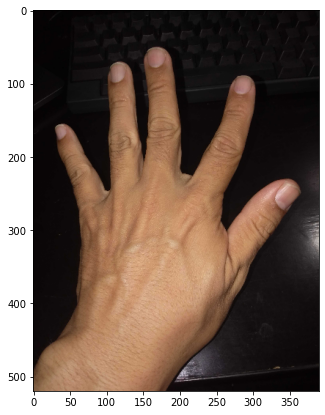

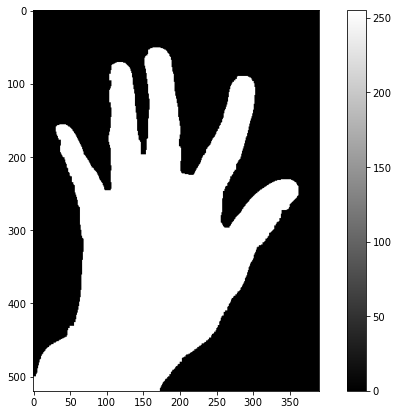

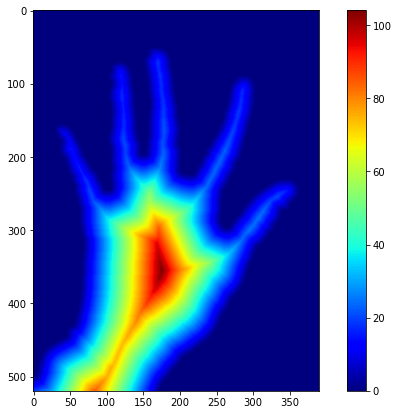

In [4]:
image = cv2.imread("MyHand2.png")

# HSV色空間に変換
image_HSV = cv2.cvtColor(image, cv2.COLOR_BGR2HSV_FULL)

# 良い感じに肌色領域を抽出
mask = (image_HSV[:,:,0] < 50) & (image_HSV[:,:,1] > 50) & (image_HSV[:,:,2] > 100)
mask = mask.astype(np.uint8) * 255
show_image(image)
#show_decomposed_images(image, image_HSV)

# オープニング＆クロージング処理によりノイズを取る
N = 7
kernel = np.ones((N,N),np.uint8)
print (kernel)

dst = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
dst = cv2.morphologyEx(dst, cv2.MORPH_OPEN, kernel)
show_image(dst)

# 距離変換の例
dist = cv2.distanceTransform(dst, distanceType=cv2.DIST_L2, maskSize=3)
show_image(dist,cmap=cm.jet)

## 細線化

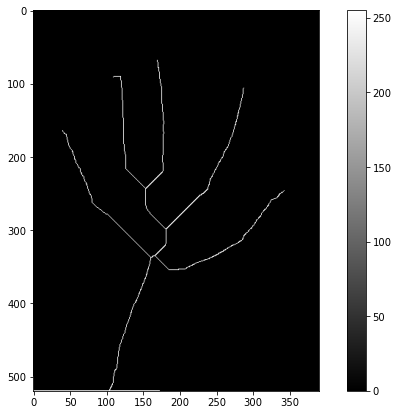

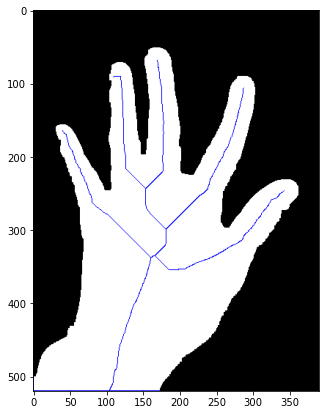

In [5]:
ret = cv2.ximgproc.thinning(dst,thinningType=cv2.ximgproc.THINNING_ZHANGSUEN)

show_image(ret)

# 元の2値画像と重ねて表示したい場合
disp = image.copy()
disp = np.zeros_like(image, dtype=np.uint8)
disp[ dst==255 , :] = (255,255,255)
disp[ ret == 255] = (255,0,0)

show_image(disp)

# 画像の変形

## いつもの画像

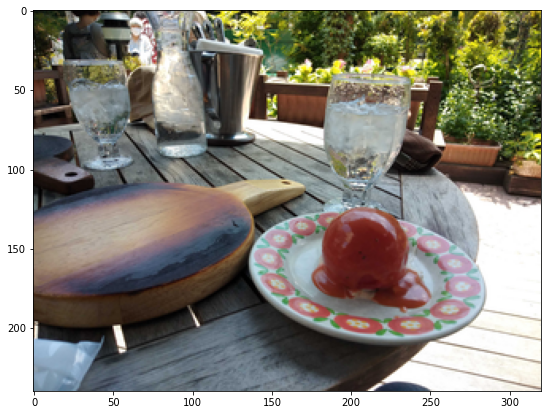

In [7]:
image = cv2.imread("tomato_sample.png")
show_image(image)
height, width, _ = image.shape

## 並進

[[  1.   0. 100.]
 [  0.   1.  40.]]


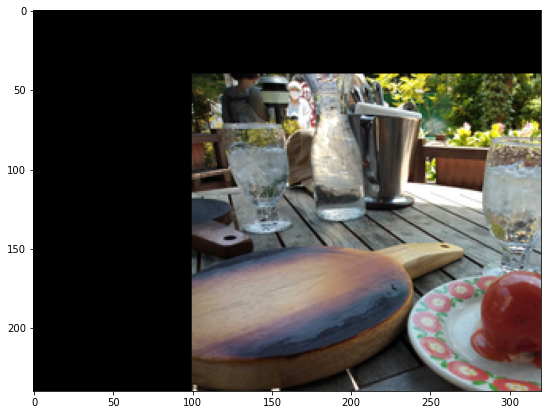

In [8]:
# 変換に必要な行列を用意して、cv2.warpAffine (cv2.warpPerspective)関数で変換します。

# 2x3の行列を作成します。
mat = np.zeros((2,3))
mat[0,0] = 1
mat[1,1] = 1
mat[0,2] = 100
mat[1,2] = 40

print(mat)

# cv2.warpAffine（元画像、行列、出力する画像のサイズ）
dst = cv2.warpAffine(image, mat, (width,height))
show_image(dst)

## 拡大・縮小

[[1.5 0.  0. ]
 [0.  1.5 0. ]]


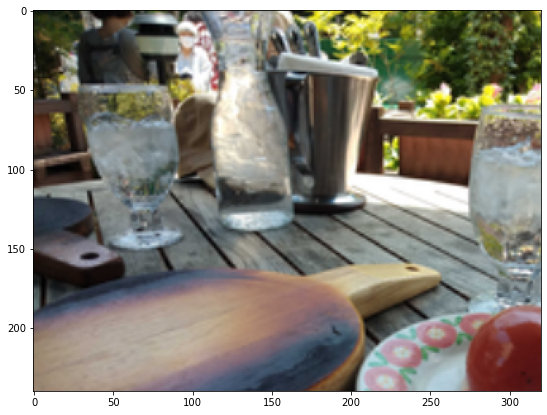

In [9]:
mat = np.zeros((2,3))
mat[0,0] = 1.5
mat[1,1] = 1.5

print (mat)

dst = cv2.warpAffine(image, mat, (width,height))
show_image(dst)

## 回転

[[  0.8660254    0.5        -38.56406461]
 [ -0.5          0.8660254   96.07695155]]


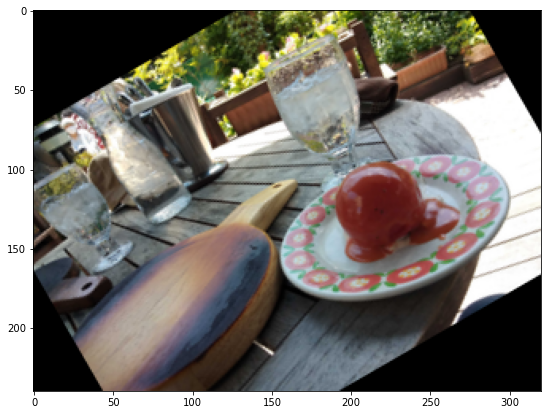

In [10]:
## 画像の中心を中心に30°回転、拡大率1.0の例です。
mat = cv2.getRotationMatrix2D((width//2,height//2), 30, 1.0)
print (mat)

dst = cv2.warpAffine(image, mat, (width,height))
show_image(dst)

## アフィン変換

[[ 0.90625 -0.125   30.     ]
 [-0.09375  0.875   30.     ]]


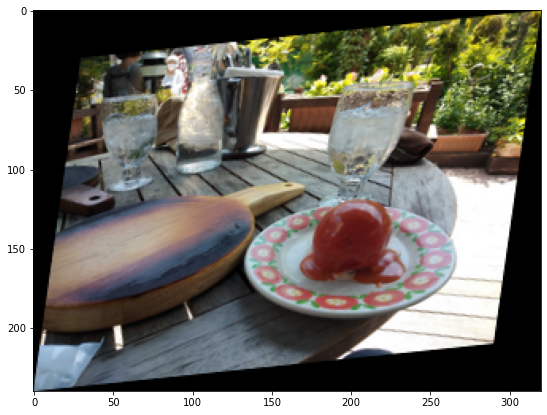

In [11]:
# (x,y)-->(x',y')の対応が3点あればアフィン変換に必要な行列を計算できます。
# 今回は、
"""
- (0,0) --> (30, 30)
- 画像の左下 --> そのまま
- 画像の右上 --> そのまま
"""
srcP = np.array([[0,0],[0,height],[width,0]], dtype=np.float32)
dstP = np.array([[30,30],[0,height],[width,0]], dtype=np.float32)

mat = cv2.getAffineTransform(srcP, dstP)
print (mat)

dst = cv2.warpAffine(image, mat, (width,height))
show_image(dst)

## 平面射影変換

[[ 4.82758621e-01 -2.08333333e-01  5.00000000e+01]
 [-1.56250000e-01  4.22413793e-01  5.00000000e+01]
 [-4.62464080e-04 -1.53855364e-03  1.00000000e+00]]


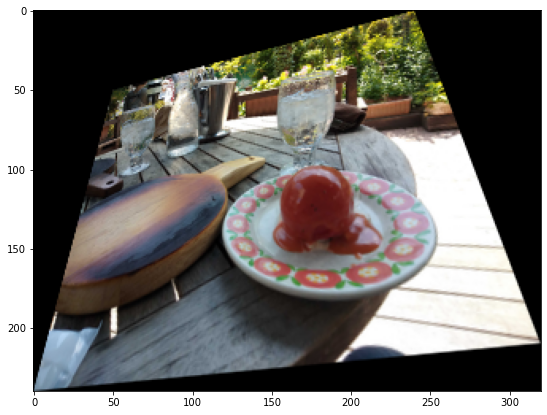

In [12]:
# (x,y)-->(x',y')の対応が4点あれば平面射影変換に必要な行列を計算できます。
# 今回は、
"""
- (0,0) --> (50, 50)
- 画像の左下 --> そのまま
- 画像の右上 --> 画像の右上から80ピクセル左
- 画像の右下 --> 画像の右下から30ピクセル上
"""

srcP = np.array([[0,0],[0,height],[width,0],[width,height]], dtype=np.float32)
dstP = np.array([[50,50],[0,height],[width-80,0],[width,height-30]], dtype=np.float32)

mat = cv2.getPerspectiveTransform(srcP, dstP)
print (mat)

# cv2.warpPerspective（元画像、行列、出力する画像のサイズ）
dst = cv2.warpPerspective(image, mat, (width,height))
show_image(dst)


## (応用)

[[ 5.74383898e-01 -2.38083369e-01 -1.08761207e+02]
 [ 1.74910404e-01  7.54831794e-01 -8.68725638e+02]
 [-9.26552805e-05  3.20957553e-04  1.00000000e+00]]


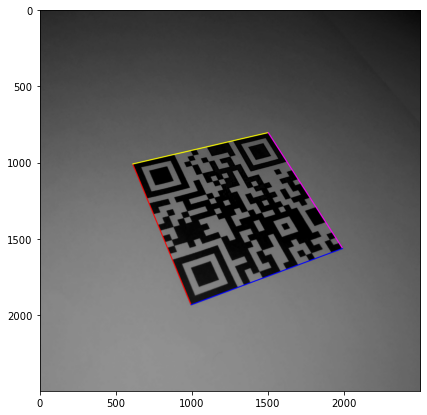

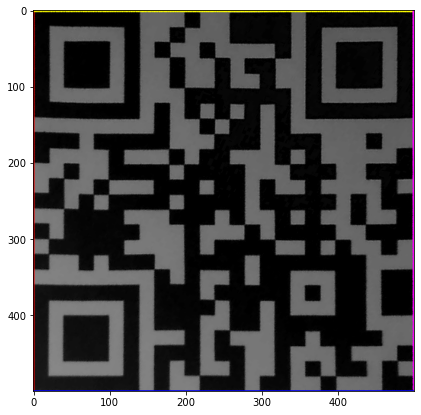

In [13]:
# ＱＲコードの4角を使って平面射影変換します。
image = cv2.imread("QR2.png")
cv2.line(image, (608,1010), (991,1934), (0,0,255), 5)
cv2.line(image, (608,1010), (1497,804), (0,255,255), 5)
cv2.line(image, (1497,804), (1985,1564), (255,0,255), 5)
cv2.line(image, (991,1934), (1985,1564), (255,0,0), 5)
show_image(image)

# QRコードの四隅の座標（本当は自動検出したいけど今回は人間が指定）⇒ (0,0), (0,500), (500,0), (500,500)
# への変換を行う平面射影行列を計算
srcP = np.array([[608,1010],[991,1934],[1497,804],[1985,1564]], dtype=np.float32)
dstP = np.array([[0,0],[0,500],[500,0],[500,500]], dtype=np.float32)

mat = cv2.getPerspectiveTransform(srcP, dstP)
print (mat)

dst = cv2.warpPerspective(image, mat, (500,500))
show_image(dst)
